<a href="https://colab.research.google.com/github/sarathi-vs13/Transformers/blob/main/ViT_on_CIFAR_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
!nvidia-smi

Mon Sep  1 09:30:29 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   74C    P0             32W /   70W |    1686MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [21]:
from google.colab import files
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
from transformers import ViTForImageClassification, ViTFeatureExtractor
import os

In [11]:
# Device & Hyperparams

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Smaller batch size for Colab T4 (avoid OOM)
batch_size = 64 if torch.cuda.is_available() else 16
epochs = 10
lr = 3e-5
checkpoint_dir = "./checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

print(f"Using device: {device}, batch_size: {batch_size}")


Using device: cuda, batch_size: 64


In [12]:
# Data

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # RGB mean/std
])

train_set = torchvision.datasets.CIFAR10(root="./data", train=True,
                                         download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10(root="./data", train=False,
                                        download=True, transform=transform)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)

In [13]:
# Model & Optimizer

# Use a smaller ViT variant (tiny)
model = ViTForImageClassification.from_pretrained(
    "facebook/deit-tiny-patch16-224",
    num_labels=10,
    ignore_mismatched_sizes=True
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=lr)

# Mixed precision scaler
scaler = torch.cuda.amp.GradScaler()




Some weights of ViTForImageClassification were not initialized from the model checkpoint at facebook/deit-tiny-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 192]) in the checkpoint and torch.Size([10, 192]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1424092301.py:14: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [14]:
print(model.classifier)


Linear(in_features=192, out_features=10, bias=True)


In [15]:
# Load Checkpoint if exists

start_epoch = 0
best_acc = 0


if os.path.exists(f"{checkpoint_dir}/last.pth"):
    checkpoint = torch.load(f"{checkpoint_dir}/last.pth", map_location=device)
    model.load_state_dict(checkpoint["model"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    start_epoch = checkpoint["epoch"] + 1
    best_acc = checkpoint["best_acc"]
    print(f"Resumed from epoch {start_epoch} (best_acc={best_acc:.2f}%)")



Resumed from epoch 2 (best_acc=94.03%)


In [16]:
# Training + Eval

def evaluate():
    model.eval()
    correct, total = 0, 0
    with torch.no_grad(), torch.cuda.amp.autocast():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    torch.cuda.empty_cache()
    return 100 * correct / total

# Training Loop

for epoch in range(start_epoch, epochs):
    model.train()
    running_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(images).logits
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()

    acc = evaluate()
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}, Acc: {acc:.2f}%")

    # Save checkpoint
    checkpoint = {
        "epoch": epoch,
        "model": model.state_dict(),
        "optimizer": optimizer.state_dict(),
        "best_acc": best_acc
    }
    torch.save(checkpoint, f"{checkpoint_dir}/last.pth")

    # Save best model
    if acc > best_acc:
        best_acc = acc
        torch.save(checkpoint, f"{checkpoint_dir}/best.pth")
        print("✅ Saved Best Model!")

print("Training complete!")


/tmp/ipython-input-2196337096.py:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipython-input-2196337096.py:6: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast():


Epoch [3/10], Loss: 0.0637, Acc: 95.23%
✅ Saved Best Model!
Epoch [4/10], Loss: 0.0397, Acc: 95.57%
✅ Saved Best Model!
Epoch [5/10], Loss: 0.0325, Acc: 95.50%
Epoch [6/10], Loss: 0.0247, Acc: 95.37%
Epoch [7/10], Loss: 0.0225, Acc: 95.15%
Epoch [8/10], Loss: 0.0180, Acc: 95.49%
Epoch [9/10], Loss: 0.0149, Acc: 95.16%
Epoch [10/10], Loss: 0.0161, Acc: 94.98%
Training complete!


In [17]:
# Inference Function

from PIL import Image

def predict_image(img_path):
    model.eval()
    img = Image.open(img_path).convert("RGB")
    transform_infer = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
    ])
    img = transform_infer(img).unsqueeze(0).to(device)
    with torch.no_grad(), torch.cuda.amp.autocast():
        outputs = model(img).logits
        _, pred = torch.max(outputs, 1)
    classes = train_set.classes
    return classes[pred.item()]



Saving test1.jpg to test1.jpg


/tmp/ipython-input-3845648098.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast():


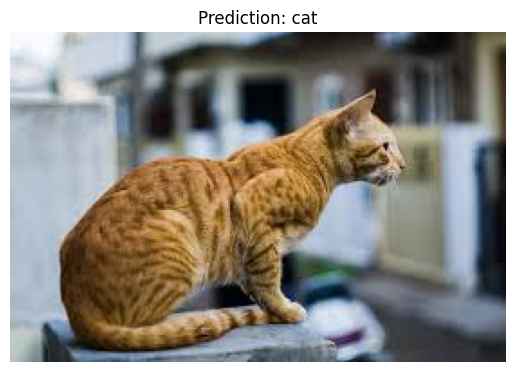

In [22]:
# User Upload & Prediction

def user_upload_and_predict():
    uploaded = files.upload()  # open file picker
    filename = list(uploaded.keys())[0]

    # Get prediction
    pred_class = predict_image(filename)

    # Display image and prediction
    img = Image.open(filename).convert("RGB")
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Prediction: {pred_class}")
    plt.show()

# Call this function
user_upload_and_predict()